In [2]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import socket
import getpass
import nntools as nt
import json
import re
from collections import defaultdict

from nltk.stem.porter import *
import string
from nltk.tokenize import word_tokenize

In [3]:
images_dir = '/datasets/ee285f-public/VQA2017/'
q_dir = '/datasets/ee285f-public/VQA2017/v2_OpenEnded_mscoco_'
ans_dir = '/datasets/ee285f-public/VQA2017/v2_mscoco_'

In [4]:
#entire cell uses code found: https://github.com/zcyang/imageqa-san/blob/master/data_vqa/process_function.py
def process_sentence(sentence):
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    commaStrip   = re.compile("(\d)(\,)(\d)")
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '>', '<', '@', '`', ',', '?', '!']
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "id've": "i'd've", "i'dve": "i'd've", \
                    "im": "i'm", "ive": "i've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    inText = sentence.replace('\n', ' ')
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:            
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    
    return outText

def process_answer(answer):
    articles = ['a', 'an', 'the']
    manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }
    new_answer = process_sentence(answer)
    outText = []
    for word in new_answer.split():
        if word not in articles:
            word = manualMap.setdefault(word, word)
            outText.append(word)
    return ' '.join(outText)

In [5]:
def myimshow(image, ax=plt):
    ax.figure()
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [14]:
class MSCOCODataset(td.Dataset):
    def __init__(self, images_dir, q_dir, ans_dir, mode='train', image_size=(448, 448)):
        super(MSCOCODataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.root_image = os.path.join(images_dir, "%s2014" % mode)
        self.qa_dict = defaultdict(list)
        
        root_q = os.path.join(q_dir + "%s2014_questions.json" % mode)
        root_ans = os.path.join(ans_dir + "%s2014_annotations.json" % mode)
        
        with open(root_q) as f:
            questions = json.load(f)['questions']
        
        with open(root_ans) as f:
            answers = json.load(f)['annotations']
        
        for q, a in zip(questions, answers):
            img_id = str(q['image_id'])
                                    
            self.qa_dict[img_id].append((process_sentence(q['question']),
                                    process_answer(a['multiple_choice_answer'])))
        
        self.qa_list = list(self.qa_dict.items())
        
        self.vocab = self.create_vocab()
        self.answers = self.get_top_answers()


    def create_vocab(self):
        #get all questions from dataloader
        questions = []

        for data in self.qa_list: 
            for qa in data[1]:
                questions.append(qa[0])
        vocab = {}
        counter = 0 
        for question in questions:
            for word in question.split(" "):
                if word not in vocab: 
                    vocab[word] = counter
                    counter = counter + 1
        return vocab
    
    def get_top_answers(self):
        answers = []
        for data in self.qa_list: 
            for qa in data[1]:
                answers.append(qa[1])   
        answer_count_dict = {}
        for answer in answers: 
            if answer not in answer_count_dict: 
                answer_count_dict[answer] = 1
            else:
                answer_count_dict[answer]+=1
        answer_counts = sorted([(answer_count_dict[answer], answer) for answer in answer_count_dict])
        print(answer_counts)
        return [answer[1] for answer in answer_counts]
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "MSCOCODataset(mode={}, image_size={})" . \
                format(self.mode, self.image_size)

    def one_hot_code_questions(self, question_answers):
        one_hot_coded_questions = len(question_answers)*[]
        for i in range(len(question_answers)):
            one_hot_coded_question = torch.zeros(len(self.vocab))
            question, answer = question_answers[i]
            for word in question.split(" "):
                if word in self.vocab: 
                    one_hot_coded_question[self.vocab[word]] = 1 
            one_hot_coded_questions.append(one_hot_coded_question)
        return one_hot_coded_questions
                        
    def __getitem__(self, idx):
        entry = self.qa_list[idx]
        img_id = entry[0]
        qa = entry[1]
 
        img_path = os.path.join(self.root_image, "COCO_%s2014_%s.jpg" % (self.mode, img_id.zfill(12)))
        
        img = Image.open(img_path).convert("RGB")
        
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
                                           tv.transforms.Normalize((0.5, 0.5, 0.5),
                                                                   (0.5, 0.5, 0.5))])
        x = transform(img)
        one_hot_coded_questions = self.one_hot_code_questions(qa)
        return x, qa, one_hot_coded_questions

In [15]:
train = MSCOCODataset(images_dir, q_dir, ans_dir, mode='train', image_size=(448, 448))
val = MSCOCODataset(images_dir, q_dir, ans_dir, mode="val", image_size=(448, 448))

[(1, '$.19'), (1, '$.89 lb'), (1, '$1'), (1, '$1.35'), (1, '$1.50'), (1, '$1.80'), (1, '$10000'), (1, '$15'), (1, '$2.00 lb'), (1, '$200'), (1, '$24'), (1, '$250'), (1, '$29'), (1, '$3.30'), (1, '$30'), (1, '$369'), (1, '$4.20'), (1, '$40'), (1, '$5.00'), (1, '$6.00'), (1, '$6.95'), (1, '$6000'), (1, '.15'), (1, '.19'), (1, '.50'), (1, '.69'), (1, '.77'), (1, '.99'), (1, '.99 lb'), (1, '0 2'), (1, '0 4'), (1, '0 feet'), (1, '0 to 12'), (1, '0.3 pounds'), (1, '0.50'), (1, '0.99'), (1, '00002322'), (1, '00022970'), (1, '002'), (1, '003'), (1, '0049'), (1, '009'), (1, '00:29'), (1, '01 13 2017'), (1, '01 14 2011'), (1, '01050'), (1, '011'), (1, '011617'), (1, '0118 948 1000'), (1, '01189481000'), (1, '013'), (1, '0151 crn'), (1, '01580 879333'), (1, '016'), (1, '02 05 2013'), (1, '02 08 2009'), (1, '02 14 2013'), (1, '020 7928 3132'), (1, '0208 555 2067'), (1, '02089630649'), (1, '021'), (1, '022'), (1, '023236'), (1, '02939'), (1, '03 09 2011'), (1, '03 1010 2'), (1, '03 31 2009'), (1, '

[(1, '#'), (1, '$1.00'), (1, '$10'), (1, '$1000000'), (1, '$15'), (1, '$150'), (1, '$2 lb'), (1, '$200'), (1, '$3.50'), (1, '$300 lb $200 lb'), (1, '$5'), (1, '$5.00'), (1, '&k'), (1, "'"), (1, '.5 lbs'), (1, '.69'), (1, '0 3'), (1, '0 feet'), (1, '0 to 3'), (1, '0.97'), (1, '00 6384'), (1, '00:38'), (1, '0230'), (1, '03 11 2010'), (1, '03 12'), (1, '0304058613 2'), (1, '047'), (1, '056 012'), (1, '056 652'), (1, '06 07 2005'), (1, '06 07 2006'), (1, '06 07 2007'), (1, '06 15 2013'), (1, '06.27.2012'), (1, '07 07 2013'), (1, '07 08 2010'), (1, '070'), (1, '08 10 2012'), (1, '08006940112'), (1, '0844 5678 666'), (1, '09 03 08'), (1, '09 10 2008'), (1, '09 15 2012'), (1, '0:00'), (1, '0:26'), (1, '0:30'), (1, '0:44'), (1, '1 02 2011'), (1, '1 1 2009'), (1, '1 2 3 4 5'), (1, '1 2 3 4 5 6 7 8 9 0'), (1, '1 3'), (1, '1 3 5'), (1, '1 4 mile'), (1, '1 7'), (1, '1 800 usa rail'), (1, '1 9'), (1, '1 and 1'), (1, '1 combing his hair'), (1, '1 cup'), (1, '1 dollar'), (1, '1 for adult 1 for child'

['$.19', '$.89 lb', '$1', '$1.35', '$1.50', '$1.80', '$10000', '$15', '$2.00 lb', '$200', '$24', '$250', '$29', '$3.30', '$30', '$369', '$4.20', '$40', '$5.00', '$6.00', '$6.95', '$6000', '.15', '.19', '.50', '.69', '.77', '.99', '.99 lb', '0 2', '0 4', '0 feet', '0 to 12', '0.3 pounds', '0.50', '0.99', '00002322', '00022970', '002', '003', '0049', '009', '00:29', '01 13 2017', '01 14 2011', '01050', '011', '011617', '0118 948 1000', '01189481000', '013', '0151 crn', '01580 879333', '016', '02 05 2013', '02 08 2009', '02 14 2013', '020 7928 3132', '0208 555 2067', '02089630649', '021', '022', '023236', '02939', '03 09 2011', '03 1010 2', '03 31 2009', '0302', '0327', '0341', '035', '03:55', '04 01 2011', '04 07 2012', '04 12 2009', '04 15 2003', '05 15 2012 11:27', '05 29 2013', '0522', '0575', '05:04', '06 02 2010', '06 05 2011', '06 08 2012', '06 60 08 8179', '06231', '063', '0659 001 5', '07', '07 15 2013', '07 22 2013', '074', '07628', '08', '08 14 2013', '08003899799', '0816', '08

<IPython.core.display.Javascript object>


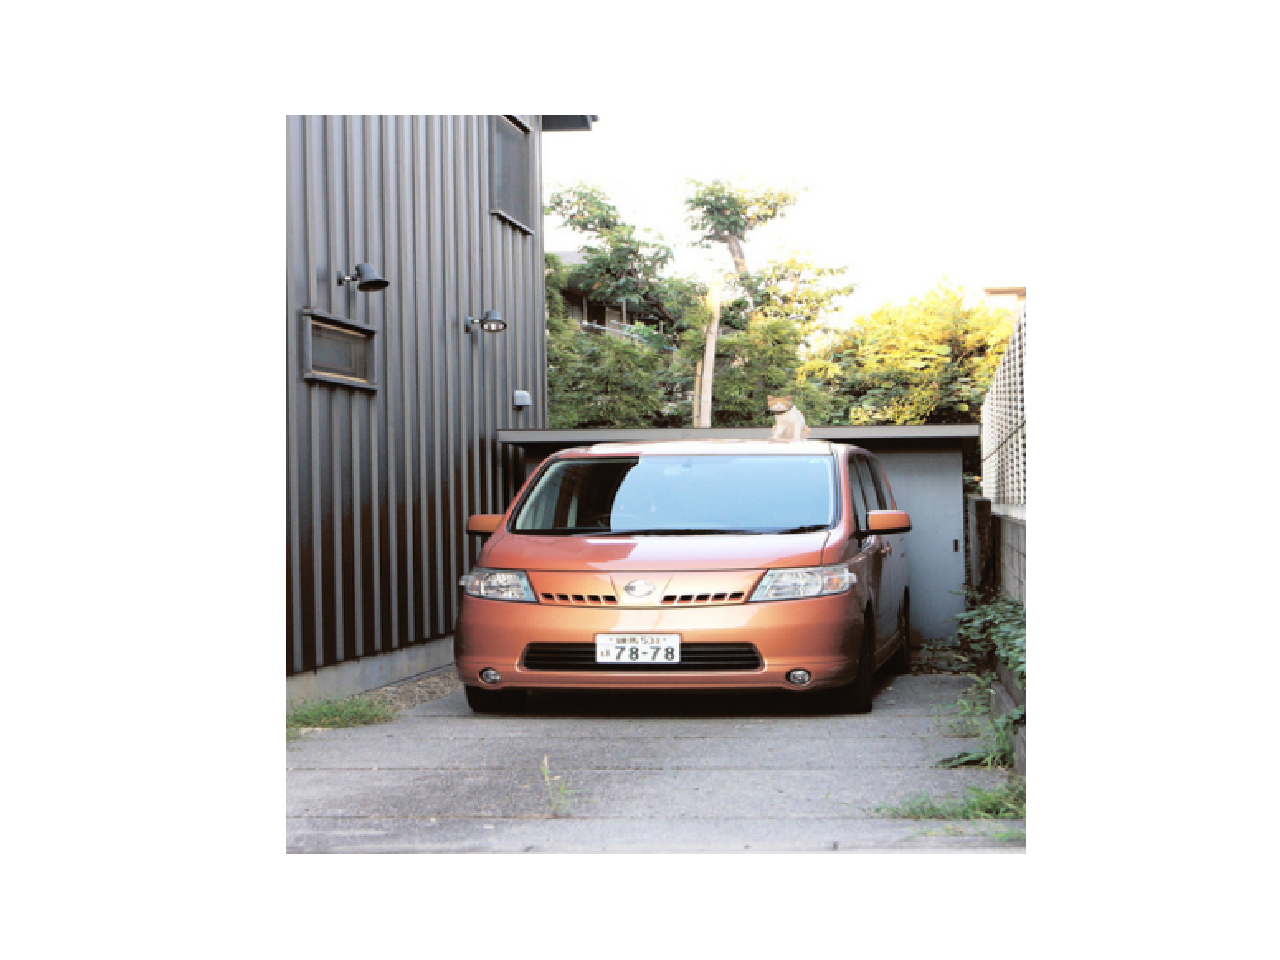

In [16]:
print(train.answers)
myimshow(train[124][0])